# Project 2: Topic Classification

### Simon Storey
### w207 Section 1 - Summer 2018

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import math 
import pandas as pd
import warnings
import sklearn.exceptions

/opt/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)


In [3]:
#take a look at the data
print("--- train ---")
print(newsgroups_train.data[:3])
print(newsgroups_train.target[:3])
print('data length: {0}'.format(len(newsgroups_train.data)))
print('target length: {0}'.format(len(newsgroups_train.target)))

print("--- test ---")
print(newsgroups_test.data[:3])
print(newsgroups_test.target[:3])
print('data length: {0}'.format(len(newsgroups_test.data)))
print('target length: {0}'.format(len(newsgroups_test.target)))

--- train ---
["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych", '\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.', "\n >In article <1

In [4]:

# split was a non integer so fix this

num_test = len(newsgroups_test.target)
split = math.floor(num_test/2)
print("size of split: {0}".format(split))

test_data, test_labels = newsgroups_test.data[split:], newsgroups_test.target[split:]
dev_data, dev_labels = newsgroups_test.data[:split], newsgroups_test.target[:split]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)

print('labels names:', newsgroups_train.target_names)


size of split: 676
training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [236]:
cv_bigram = CountVectorizer(ngram_range=(2,2)) 
dtm_bigram = cv_bigram.fit_transform(train_data)
s=[1,2,3]
np.array(cv_bigram.get_feature_names())[s]

array(['00 12', '00 13', '00 21'], dtype='<U161')

(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [6]:

def P1(labels, data,num_examples=5):
### STUDENT START ###
    """
    Extract top num_examples from labels and data
    """
    df = pd.DataFrame(columns=('label', 'txt'))
    for i in range(1,num_examples+1):
        new = [labels[i],data[i]]
        df.loc[i] = new
        
    return df

### STUDENT END ###
r=P1(train_labels, train_data,5)
r

,label,txt
1,3,"\n\nSeems to be, barring evidence to the contr..."
2,2,\n >In article <1993Apr19.020359.26996@sq.sq.c...
3,0,I have a request for those who would like to s...
4,2,AW&ST had a brief blurb on a Manned Lunar Exp...
5,0,\nThere are definitely quite a few horrible de...


### (2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

#### a. The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:
 
* What is the size of the vocabulary? 
* What is the average number of non-zero features per example? 
* What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.

In [203]:
def P2a(dtm):
    """
    Generate info about sparse matrix
    """
    s = dtm.shape
    perc = 100*dtm.nnz/(s[0]*s[1])
    no_examples = s[0]
    
    print('Document term matrix')
    print('Shape : {0}'.format(s))
    print('Number of Examples: {0}'.format(no_examples))    
    print('Vocab (#features) size: {0}'.format(s[1]))
    print('Number of non zeros: {0}'.format(dtm.nnz))
    print('Percentage of non zeros % : {0:.2f}'.format(perc))
    
    # get none zero features per row
    x=dtm.getnnz(axis=0)
    print('min: {0}, max: {1}, mean: {2:.2f} of non-zero features per example'.format(np.min(x),np.max(x),np.mean(x)))
       
# Create countVectorizer and then learn the vocab dictionary(train_data) and return a document term matrix (n_samples,n_features)
cv = CountVectorizer() 
dtm = cv.fit_transform(train_data)

# Generate info about the document term matrix
P2a(dtm)


Document term matrix
Shape : (2034, 26879)
Number of Examples: 2034
Vocab (#features) size: 26879
Number of non zeros: 196700
Percentage of non zeros % : 0.36
min: 1, max: 1683, mean: 7.32 of non-zero features per example


#### b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

In [147]:
def P2b(cv, count=1):
    """
    Get first and last terms from feature integer indices and feature names
    """
    fn = cv.get_feature_names()
    return fn[0:count],fn[-count:]
    
print(P2b(cv))

(['00'], ['zyxel'])


#### c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. 
Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

In [148]:
# P2c - override vocab in CountVectorizer class initializer

vocabularly = ["atheism", "graphics", "space", "religion"]

cv2 = CountVectorizer(vocabulary=vocabularly) 
dtm2 = cv2.fit_transform(train_data)

# Generate info about tdm sparse matrix ( reuse function from P2a )
P2a(dtm2)

# What size vocabulary does this yield?
# 4

Document term matrix
Shape : (2034, 4)
Number of Examples: 2034
Vocab (#features) size: 4
Number of non zeros: 546
Percentage of non zeros % : 6.71
Average number of non-zero features per example: 0.27


#### d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. 
What size vocabulary does this yield?

In [149]:
# P2d - Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

cv_ngram = CountVectorizer(analyzer="char", ngram_range=(2,3)) 
dtm_ngram = cv_ngram.fit_transform(train_data)

# Generate info about dtm_ngram sparse matrix ( reuse function from P2a )
P2a(dtm_ngram)

# Lets look at the top5 and bottom5 ngrams ( reuse function from P2b )
print(P2b(cv_ngram, count=5))

# What size vocabulary does this yield?
# 35478

Document term matrix
Shape : (2034, 35478)
Number of Examples: 2034
Vocab (#features) size: 35478
Number of non zeros: 1391646
Percentage of non zeros % : 1.93
Average number of non-zero features per example: 684.19
(['\x08i', '\x08ib', '\t"', '\t"i', '\t"o'], ['ý ', 'ý 1', 'þ ', 'þ d', 'þ h'])


#### e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

In [273]:
# P2e - Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

cv_min = CountVectorizer(min_df=10) 
dtm_min = cv_min.fit_transform(train_data)

# Generate info about dtm_ngram sparse matrix ( reuse function from P2a )
P2a(dtm_min)

# What size vocabulary does this yield?
# 3064

Document term matrix
Shape : (2034, 26879)
Number of Examples: 2034
Vocab (#features) size: 26879
Number of non zeros: 147823
Percentage of non zeros: 0.27
Average number of non-zero features per example: 72.68


#### f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 
Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [274]:
# P2f - Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 
#       Hint: build a vocabulary for both train and dev and look at the size of the difference.

cv_dev = CountVectorizer() 
dtm_dev = cv_dev.fit_transform(dev_data)

train_words = cv.get_feature_names()
dev_words = cv_dev.get_feature_names()

no_words_only_in_dev = len(set(dev_words) - set(train_words))
print("no words only in dev but not in train: {0}".format(no_words_only_in_dev))
print("proportion vs. train: {0:.4f}%".format(100*no_words_only_in_dev/len(train_words)))
print("proportion vs. dev: {0:.4f}%".format(100*no_words_only_in_dev/len(dev_words)))


no words only in dev but not in train: 4027
proportion vs. train: 14.9820%
proportion vs. dev: 24.7876%


## ANSWERS

### (3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. 

See code below that runs the following classifiers ( k nearest neighbors classifier, multinomial naive bayes and logistic regression ) and calculates the f1-score:

In [13]:
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def P3_search_and_score(clf, x_train, y_train, x_test, y_test, param_grid, cross_validation, scoring):
    """
    Perform grid search, fit model and print out model, best params and score
    """
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cross_validation, scoring=scoring, verbose=1)
    gs.fit(x_train,y_train) 
    print(clf)
    print(gs.best_params_)
    print(gs.best_score_)
        
# Transform data to document term matrix        
dtm_train_data = cv.transform(train_data)
dtm_test_data = cv.transform(test_data)
cross_validation = 10

# Search and score KNN, MNB and LR ( using default penalty="l2" )
P3_search_and_score(KNeighborsClassifier(), dtm_train_data, train_labels, dtm_test_data, test_labels, {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10]}, cross_validation, 'f1_weighted')
P3_search_and_score(MultinomialNB(), dtm_train_data, train_labels, dtm_test_data, test_labels, {'alpha' : [1.0e-10,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}, cross_validation, 'f1_weighted')
P3_search_and_score(LogisticRegression(), dtm_train_data, train_labels, dtm_test_data, test_labels, {'C' : [0.01,0.1,0.3,0.5,0.7,1]}, cross_validation, 'f1_weighted')


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
{'n_neighbors': 8}
0.44084774159751094
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.7s finished


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
{'alpha': 0.01}
0.8390500779008734
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'C': 0.5}
0.781680469327559


My results are as follows:
    
| Classifier | Optimal | F1-score (weighted) |
| --- | --- | --- |
| KNeighborsClassifier | n_neighbors: 8 | 0.44 |
| MultinomialNB | alpha : 0.01 | 0.84 |
| LogisticRegression | C : 0.5 | 0.78 |

#### a. Why doesn't nearest neighbors work well for this problem?

When there are a high number of features ( i.e. vocab ), there is little difference between the nearest and farthest neighbours. A better measure would be some variant of similiarity ( i.e. cosine )


#### b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Logisitic regression is a discriminative model ( and minimizes error ), whereas Naive Bayes is a generative model and it estimates a joint probability from the training data provided.
Logisitic regression is much slower to classify the training data than the Naive Baynes classifier, this can be observed even when training the fit with the data provided.

Based on the paper "On Discriminative vs. Generative classifiers: A comparison of logistic regression and naive Bayes" by Andrew Y. Ng and Michael I. Jordan, they discuss that NB classifiers converge more quickly than LR classifiers. They also demonstrate as the number of training examples increase, initially NB does better, but, LR will eventually catch up and quite likely overtake the performance of NB if enough examples are made available.  

So, in our example, we probably do not have enough examples to see this behaviour and we are experiencing NB converging quickly to its higher asymptotic error and it thus outperforms LR. In our example I assume we do not have enough examples for it to converge to the lower asymptotic error and thus outperform NB.


#### c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

Smaller values of C result in stronger L2 regularization. This will mean the smaller the value of C, more and more feature coefficients will be driven to a value of zero. We can see as C increases, the sum of the squared weight values increases as more and more coefficients now have a non-zero value.
 
The use of regularization and small values of C lead us towards a more parsiminious models that better generalizes the training data set but could underfit the training data, to large a value of C would lead to a complex model that overfits the training data. The regularization term is helping us trade off model complexitity vs. improved model fit. 


In [326]:
# 3c - Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. 
#      Output the sum of the squared weight values for each class for each setting of the C parameter. 
#      Briefly explain the relationship between the sum and the value of C.

def P3c(x_train, y_train, c_regularizations):
    """
    Fit LR and calc sum of the squared weight values for each class (by C parameter)
    """
    lr = LogisticRegression()
    for c in c_regularizations:
        lr.C = c
        lr.fit(x_train,y_train)
        # get coef ~ (n_classes, n_features)
        print('c_regularization: {0}'.format(c))
        print('sum of the squared weight (across all classes and categories): {0}'.format((lr.coef_**2).sum()))
        print('sum of the squared weight (across all classes for each category ~ ): {0}'.format((lr.coef_**2).sum(axis=1)))
        print('sum of the squared weight (for top 5 classes ~ ): {0}'.format((lr.coef_**2).sum(axis=0)[:5]))
        
P3c(dtm_train_data, train_labels, [0.01,0.1,0.3,0.5,0.7,1])


c_regularization: 0.01
sum of the squared weight (across all classes and categories): 10.59368561488394
sum of the squared weight (across all classes for each category ~ ): [2.5414782  2.93970937 2.86246884 2.25002921]
sum of the squared weight (for top 5 classes ~ ): [1.18631461e-03 1.31142254e-03 3.92161098e-05 1.56864439e-04
 8.29312824e-13]
c_regularization: 0.1
sum of the squared weight (across all classes and categories): 102.27283904748042
sum of the squared weight (across all classes for each category ~ ): [27.12950075 24.65904876 27.45823702 23.02605251]
sum of the squared weight (for top 5 classes ~ ): [1.05646427e-02 6.88338269e-03 9.02185123e-05 3.60874049e-04
 2.80641566e-12]
c_regularization: 0.3
sum of the squared weight (across all classes and categories): 254.84390059918664
sum of the squared weight (across all classes for each category ~ ): [69.28544111 57.87520692 67.90040487 59.7828477 ]
sum of the squared weight (for top 5 classes ~ ): [2.47797290e-02 1.40623504e-0

#### (4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [259]:
import itertools

def extract_topN(clf,feature_names, num_features=5, showOutput=True):
    """
    Helper to extract df of top X coefficients and feature names
    """
    
    # Loop over each set of labels
    
    results = []
    for i in range(0,4):
        
        # Get coef, feature names and then sort (desc order)
        l=list(zip(clf.coef_[i],range(len(feature_names))))
        l.sort(reverse=True)
        
        # Transform into dict ( for dataframe init )
        r=dict([(feature_names[b],a) for a,b in l][:num_features])
        
        # print results
        if (showOutput):
            print('--- top {0} words for {1}'.format(num_features,newsgroups_train.target_names[i]))
            print(r)
        
        # append feature indexes to results
        results = itertools.chain(results,[b for a,b in l][:num_features])                                  
        
    return list(results)



def extract_df(clf, feature_names, feature_indexes):
    """
    Helper to extract df of feature names and coefficients
    """
    
    # Loop over each set of labels
    results = {}
    for i in range(0,4):
        
        # Get coef, feature names and then sort (desc order)
        l=list(zip(np.array(clf.coef_[i])[feature_indexes],np.array(feature_names)[feature_indexes]))
        
        # Transform into dict ( for dataframe init )
        r=dict([(b,a) for a,b in l])
                
        results[newsgroups_train.target_names[i]] = r
        
    return pd.DataFrame(results)


def extract(clf, feature_names,num_features=5, showOutput=False ):
    feature_indexes = extract_topN(clf, feature_names, num_features, showOutput)
    return extract_df(clf, feature_names, feature_indexes) 


def fit_LR(x_train, y_train, c=0.5):
    """
    Fit LR and use default c~0.5 ( based on prior search 
    """
    clf = LogisticRegression()
    clf.C = c
    clf.fit(x_train,y_train)
    
    return clf


def p4():

    # Fit LR and extract # of features with largest weights for words 
    # Use feature names from CountVectorizer ( defined in q1 )
    lr = fit_LR(dtm_train_data, train_labels)

    print('--- word results ---')
    word_indexes = extract_topN(lr, cv.get_feature_names())

    # Repeat defining new CountVectorizer for bigram and fit
    cv_bigram = CountVectorizer(ngram_range=(2,2)) 
    dtm_bigram = cv_bigram.fit_transform(train_data)
    lr_bigram = fit_LR(dtm_bigram, train_labels)

    print('--- bigram result ---')
    bigram_indexes = extract_topN(lr_bigram, cv_bigram.get_feature_names())

    # -- Show table (df) of all words ( and coefficients for each label )

    # Show results
    print('--- word results ---')
    print(extract_df(lr, cv.get_feature_names(), word_indexes))
    
    print('--- bigram results ---')
    print(extract_df(lr_bigram, cv_bigram.get_feature_names(), bigram_indexes))

    
p4()

--- word results ---
--- top 5 words for alt.atheism
{'atheists': 0.8343019356293478, 'bobby': 0.8234861316081121, 'religion': 0.798327426918692, 'atheism': 0.7948850964797187, 'deletion': 0.7237719690153397}
--- top 5 words for comp.graphics
{'graphics': 1.6264485111773876, 'image': 1.1168221825524032, 'file': 1.0589496533804172, '3d': 0.9414597931975359, 'computer': 0.843823797899266}
--- top 5 words for sci.space
{'space': 1.8641492820381993, 'orbit': 1.0127510306412784, 'nasa': 0.8516915193334254, 'launch': 0.783903297220181, 'spacecraft': 0.7373899051370345}
--- top 5 words for talk.religion.misc
{'christians': 0.9293985521619428, 'christian': 0.9255918810716137, 'blood': 0.8470027616022655, 'fbi': 0.7547271612739409, 'order': 0.7429687112083067}
--- bigram result ---
--- top 5 words for alt.atheism
{'claim that': 0.6055485573518684, 'cheers kent': 0.555719434109401, 'was just': 0.48205043142231097, 'you are': 0.4727407108411415, 'are you': 0.44695367639789607}
--- top 5 words for

### ANSWER:

I some of the most common words also appear in the bi-gram analysis, but not as many as I would of initially expected. This must be because the common words and not as common in a bi-gram pair, and the alternate word and the variety of this reduces the frequency of occurrences, c/w other bigrams in the documents.


(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [4]:
# Download stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [262]:
# #### NO PREPROCESSING ####

# Create countVectorizer and then learn the vocab dictionary(train_data) and return a document term matrix (n_samples,n_features)
cv_none = CountVectorizer()
dtm_none = cv_none.fit_transform(train_data)

# Generate info about the document term matrix
P2a(dtm_none)

# Now re-run our LR, using function from q4
lr_none = fit_LR(dtm_none, train_labels)
none_results = extract(lr_none,cv_none.get_feature_names())

# Show results
print('--- word results using NO preprocessor ---')
print(none_results)

# Predict and get f1-score
dtm_none_test_data = cv_none.transform(test_data)
result_none = lr_none.predict(dtm_none_test_data)

print ('--- NO Preprocessor ---')
print (classification_report(test_labels, result_none))



Document term matrix
Shape : (2034, 26879)
Number of Examples: 2034
Vocab (#features) size: 26879
Number of non zeros: 196700
Percentage of non zeros % : 0.36
min: 1, max: 1683, mean: 7.32 of non-zero features per example
--- word results using NO preprocessor ---
            alt.atheism  comp.graphics  sci.space  talk.religion.misc
3d            -0.303430       0.941460  -0.571106           -0.317599
atheism        0.794885      -0.348540  -0.367224           -0.377014
atheists       0.834302      -0.093275  -0.267485           -0.637642
blood         -0.428762      -0.096749  -0.230769            0.847003
bobby          0.823486      -0.191203  -0.286428           -0.387225
christian     -0.482926      -0.339030  -0.247445            0.925592
christians    -0.607363      -0.315386  -0.404450            0.929399
computer       0.071355       0.843824  -0.569510           -0.396135
deletion       0.723772      -0.249529  -0.272483           -0.270445
fbi           -0.244004      -0.217

In [263]:
def better_preprocessor(s):
    """
    My better processor that strips 
     all characters not ~ a-z 
     concurrent spaces
     also handles ' so words like I've become Ive, not I ve
    """
    s = s.lower()
    s = re.sub('[\']+', '', s)
    s = re.sub('[^a-z]+', ' ', s)
    
    return s


# Stem stopwords, otherwise may be ignored
porter = PorterStemmer()
better_stop_words = [ porter.stem(w) for w in stopwords.words('english')]


# Analyzer to stem words in docs
analyzer = CountVectorizer().build_analyzer()
def better_analyzer(doc):
    return (porter.stem(w) for w in analyzer(doc))


# Create countVectorizer and then learn the vocab dictionary(train_data) and return a document term matrix (n_samples,n_features)
# Use the better_preprocessor, stopwords
cv_pre = CountVectorizer(preprocessor=better_preprocessor, analyzer=better_analyzer, stop_words=better_stop_words)
dtm_pre = cv_pre.fit_transform(train_data)

# Generate info about the document term matrix
P2a(dtm_pre)

# Now re-run our LR, using function from q4
lr_pre = fit_LR(dtm_pre, train_labels)
pre_results = extract(lr_pre, cv_pre.get_feature_names())

# Show results
print('--- word results using preprocessor ---')
print(pre_results)

# Test pre-processed and get f1-score
dtm_pre_test_data = cv_pre.transform(test_data)
result_pre = lr_pre.predict(dtm_pre_test_data)

print ('--- Preprocessing ---')
print (classification_report(test_labels, result_pre))

Document term matrix
Shape : (2034, 19677)
Number of Examples: 2034
Vocab (#features) size: 19677
Number of non zeros: 186092
Percentage of non zeros % : 0.46
min: 1, max: 1683, mean: 9.46 of non-zero features per example
--- word results using preprocessor ---
           alt.atheism  comp.graphics  sci.space  talk.religion.misc
3d           -0.281509       0.843974  -0.562299           -0.335547
atheist       1.049925      -0.166926  -0.439752           -0.754648
blood        -0.446999      -0.175356  -0.155709            0.978838
bobbi         0.761852      -0.139475  -0.274093           -0.368646
christian    -0.526269      -0.568698  -0.530476            0.980946
fbi          -0.234637      -0.209386  -0.343773            0.670070
file         -0.544963       1.169595  -0.607748           -0.766223
graphic      -0.665367       1.619082  -1.135697           -0.614979
imag         -0.669504       1.003826  -0.560495           -0.502227
islam         0.848794      -0.229586  -0.507901

After stemming, stop word removal, removal of all punctuation, the overall f1 score decreased marginally vs. increased. The feature matrix is more dense, as we have 9.46 non-zero features per example BUT I would of expected the f1-score to increase NOT decrease. Raise as a question for discussion in class..

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [98]:
def fit_LR_with_regularization(x_train,y_train, regularization_penalty, c, tolerance=0.0001):
    """
    Train LR classifier
    """
    
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    clf = LogisticRegression(penalty=regularization_penalty, tol=tolerance)
    clf.C = c
    clf.fit(x_train,y_train)
    
    return clf


# Fit LR using L1 & L2 regularization
cv = CountVectorizer()
dtm = cv.fit_transform(train_data)

l2_clf = fit_LR_with_regularization(dtm, train_labels,"l2",1)
l1_clf = fit_LR_with_regularization(dtm, train_labels,"l1",1)

# Compare # of non-zero weights ( remember this is across 4 labels / categories ! )
print('l2 nz: {0}',np.count_nonzero(l2_clf.coef_))
print('l1 nz: {0}',np.count_nonzero(l1_clf.coef_))


l2 nz: {0} 107516
l1 nz: {0} 1654


The use of l1 regularization has reduced the number of features massively to a mere 1654 ( approx 98.5% of that from L2 ) using the default regularization value of 1.

In [112]:
# Now use L1 vocab, with L2 classifier
# Extract vocab and labels (to match) where coefficient !=0
new_vocab = [v[1] for v in list(zip(l1_clf.coef_[0],cv.get_feature_names())) if v[0]!=0]

# Show 
print('sample of 10 items from vocab: {0}'.format(new_vocab[:10]))
print('count of vocab: {0} so max # of coefficients will be {1} due to 4 categories/labels'.format(len(new_vocab),4*len(new_vocab)))

# Retrain LR model using new vocab
new_cv = CountVectorizer(vocabulary=new_vocab)
new_dtm = new_cv.fit_transform(train_data)
new_dtm_test = new_cv.transform(test_data)

# Iterate over varying values of C, calculate score and # of nz coefficients
results=[]
c_values = (500,250,100,50,10,5,1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,0.001)
for c in c_values:
    clf = fit_LR_with_regularization(new_dtm, train_labels,"l1",c, 0.01)
    pred = clf.predict(new_dtm_test)    
    score = metrics.accuracy_score(test_labels, pred)
    count_nz = np.count_nonzero(clf.coef_)
    results.append((count_nz,100*score))

# Show results    
print(*zip(*results))

# Best score for C ~ 0.9

sample of 10 items from vocab: ['10', '15', '24', '3d', 'abortion', 'according', 'action', 'actually', 'add', 'agreed']
count of vocab: 437 so max # of coefficients will be 1748 due to 4 categories/labels
(1741, 1737, 1730, 1716, 1636, 1576, 1201, 1145, 1108, 1062, 969, 882, 802, 670, 527, 295, 168, 34, 5) (64.99261447562778, 65.4357459379616, 66.91285081240767, 66.02658788774004, 67.20827178729691, 66.46971935007386, 67.94682422451994, 68.24224519940915, 67.94682422451994, 67.0605612998523, 67.3559822747415, 66.91285081240767, 66.76514032496307, 67.79911373707533, 67.65140324963073, 63.36779911373708, 60.56129985228951, 47.56277695716396, 28.65583456425406)


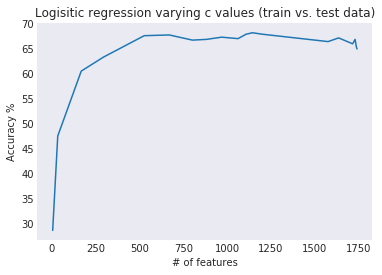

In [116]:
plt.plot(*zip(*results))
plt.ylabel('Accuracy %')
plt.xlabel('# of features')
plt.title('Logisitic regression varying c values (train vs. test data)')
plt.show()

Its interesting to see the regularization parameter coming into effect and penalizing coefficients and then driving the accuracy score down. The best value of C ~ 0.9, with an accuracy of 68%.

### (7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? 

A _TfidVectorizer_ is the equivalent of a pipeline consisting of a _CountVectorizer_ followed by a _TfidfTransformer_

#### a. Train a logistic regression model with C=100.

#### b. Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

$$ R = \frac{maximum \space predicted \space probability}{predicted \space probability \space of \space the \space correct \space label} $$

#### c. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Top 3 R values : [287.17928855 325.00396305 929.35728556]


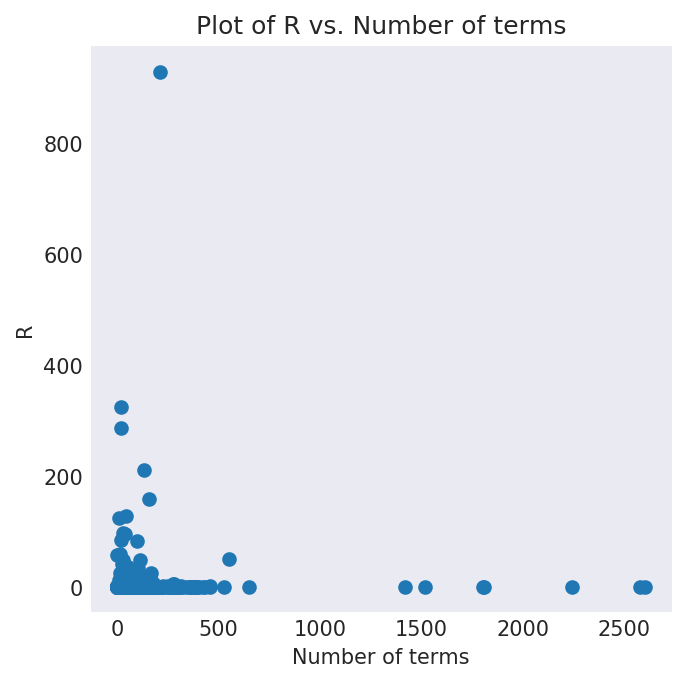

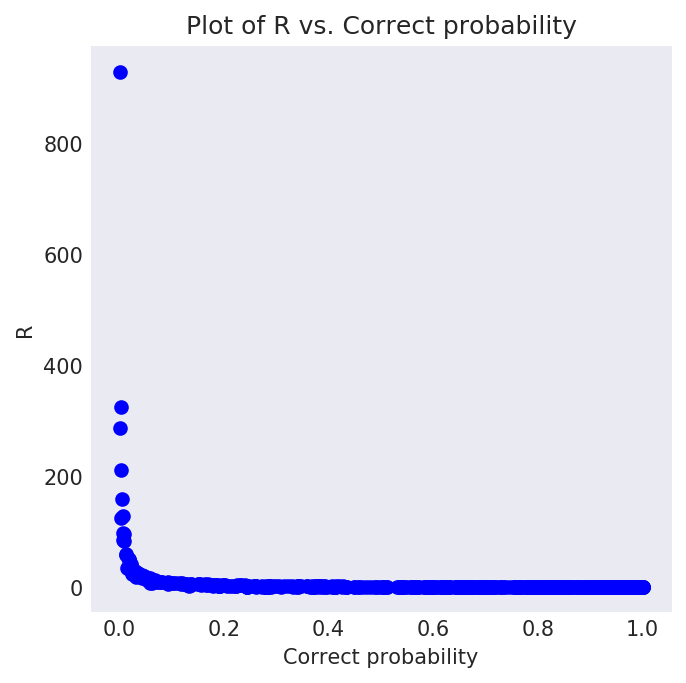

             precision    recall  f1-score   support

          0       0.69      0.62      0.65       165
          1       0.80      0.91      0.85       185
          2       0.83      0.83      0.83       199
          3       0.68      0.64      0.66       127

avg / total       0.76      0.76      0.76       676



In [359]:
#def P7():

t_cv = TfidfVectorizer()
tfidf = t_cv.fit_transform(train_data)

# Create LR classifier and fit to tfidf ( from train data )
clf = LogisticRegression()
clf.C = 100
clf.fit(tfidf,train_labels)
# Create tfidf from dev_data and predict based on LR classifier
tfidf_dev = t_cv.transform(dev_data)
p = clf.predict_proba(tfidf_dev)

# Create mask to extract probability for correct label
mask = [ (i==0,i==1,i==2,i==3) for i in dev_labels ]
correct_prob = np.extract(mask, p)
Rc = list(zip(np.divide(p.max(axis=1), correct_prob),correct_prob))

# Get top3 R values
print('Top 3 R values : {0}'.format(np.sort([x for x,y in Rc])[-3:]))

Rx = tfidf_dev.getnnz(axis=1)
Ry = [ r[0] for r in Rc]

# Plot R vs. # terms per document (scatter)
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150
plt.scatter(Rx,Ry)
plt.ylabel('R')
plt.xlabel('Number of terms')
plt.title('Plot of R vs. Number of terms')
plt.show()

Rx = [ r[1] for r in R]
Ry = [ r[0] for r in R]

# Plot R vs. # terms per document (scatter)
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150

plt.scatter(Rx,Ry, c='b', label='1')
plt.ylabel('R')
plt.xlabel('Correct probability')
plt.title('Plot of R vs. Correct probability')
plt.show()

# Get classification report
p2 = clf.predict(tfidf_dev)
print (classification_report(dev_labels, p2))

It appears when the correct probability is very small, the model fits these features poorly and this results in the dramatic swing in the values of R. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

Firstly I changed the value of C for L2 regularization, using C=40 I was able to keep the same f1-score and reduce the upper limit of R to < 250. 

             precision    recall  f1-score   support

          0       0.69      0.62      0.65       165
          1       0.80      0.90      0.85       185
          2       0.82      0.83      0.83       199
          3       0.67      0.63      0.65       127

avg / total       0.76      0.76      0.76       676

Changing C below this resulted in small adjustments to the f1-score but dramatically reduced R. Setting C =5, reduced R to be < 25 and f1-score was 0.75

             precision    recall  f1-score   support

          0       0.68      0.62      0.65       165
          1       0.79      0.90      0.84       185
          2       0.80      0.85      0.82       199
          3       0.68      0.56      0.61       127

avg / total       0.75      0.75      0.75       676

Then, I considered using L1 regularization.

Top 3 R values for l1 ~ C=0.1 : [1.96293342 2.25875069 2.29602704]


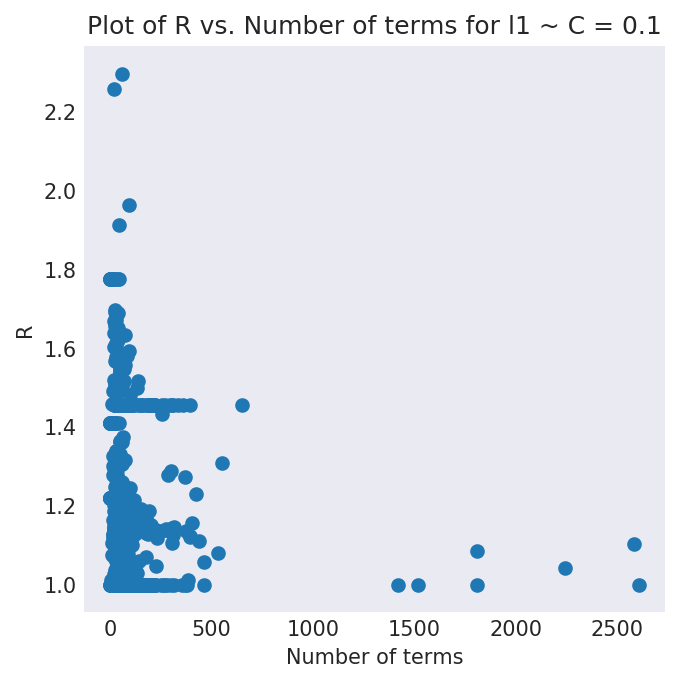

/opt/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       165
          1       0.37      0.79      0.51       185
          2       0.41      0.58      0.48       199
          3       0.00      0.00      0.00       127

avg / total       0.22      0.39      0.28       676

Top 3 R values for l1 ~ C=0.5 : [ 4.72153509  7.80152762 15.05573142]


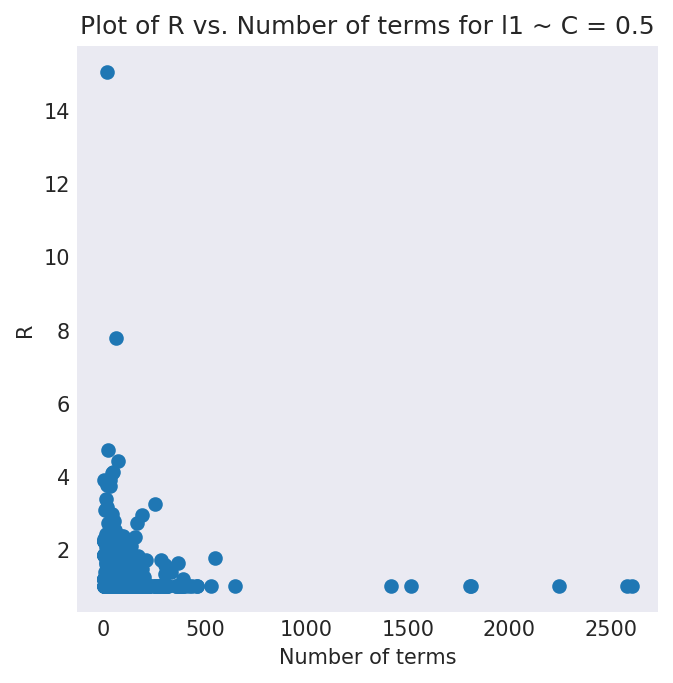

             precision    recall  f1-score   support

          0       0.53      0.50      0.51       165
          1       0.63      0.85      0.72       185
          2       0.69      0.72      0.70       199
          3       0.56      0.28      0.37       127

avg / total       0.61      0.62      0.60       676

Top 3 R values for l1 ~ C=0.9 : [ 7.31188952  9.17306721 26.27172178]


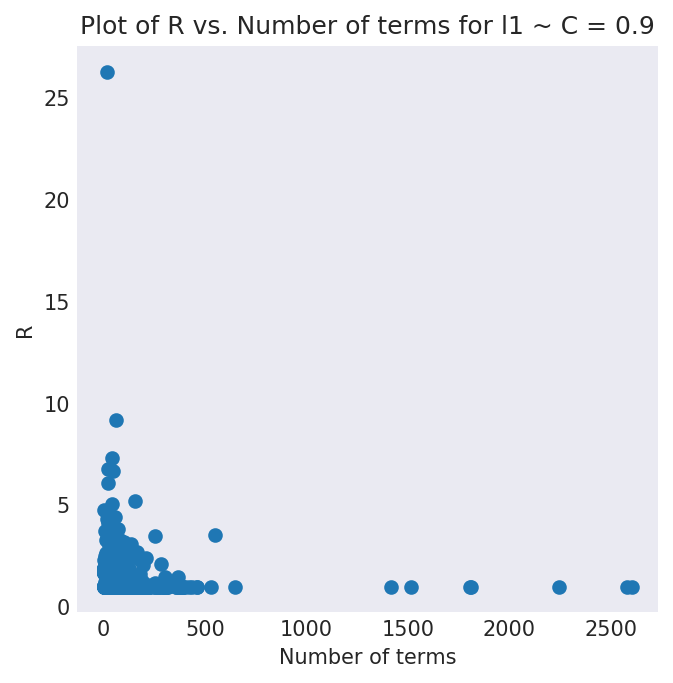

             precision    recall  f1-score   support

          0       0.59      0.53      0.56       165
          1       0.72      0.84      0.77       185
          2       0.72      0.82      0.77       199
          3       0.57      0.39      0.46       127

avg / total       0.66      0.67      0.66       676

Top 3 R values for l1 ~ C=1 : [ 8.35898602  8.77011811 28.24917672]


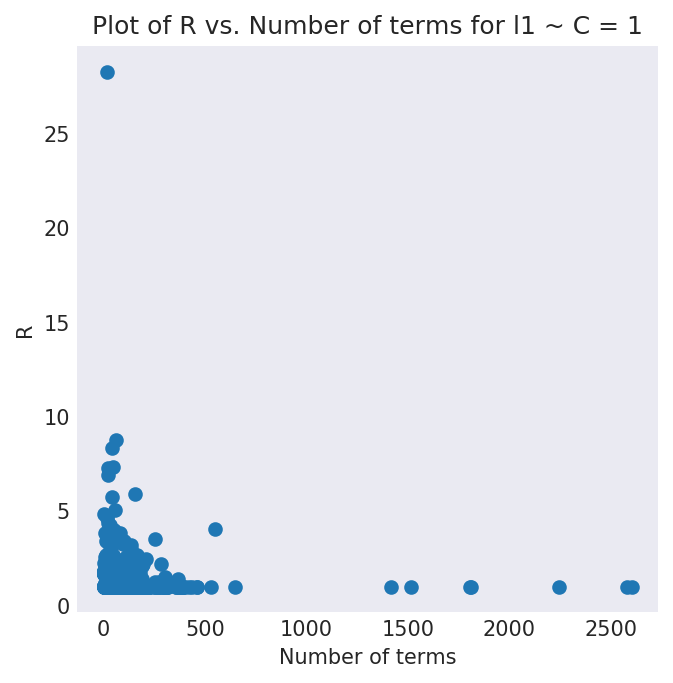

             precision    recall  f1-score   support

          0       0.59      0.54      0.57       165
          1       0.72      0.84      0.78       185
          2       0.73      0.83      0.78       199
          3       0.58      0.39      0.47       127

avg / total       0.67      0.68      0.67       676

Top 3 R values for l1 ~ C=5 : [  90.31473297  139.79574529 3181.58937309]


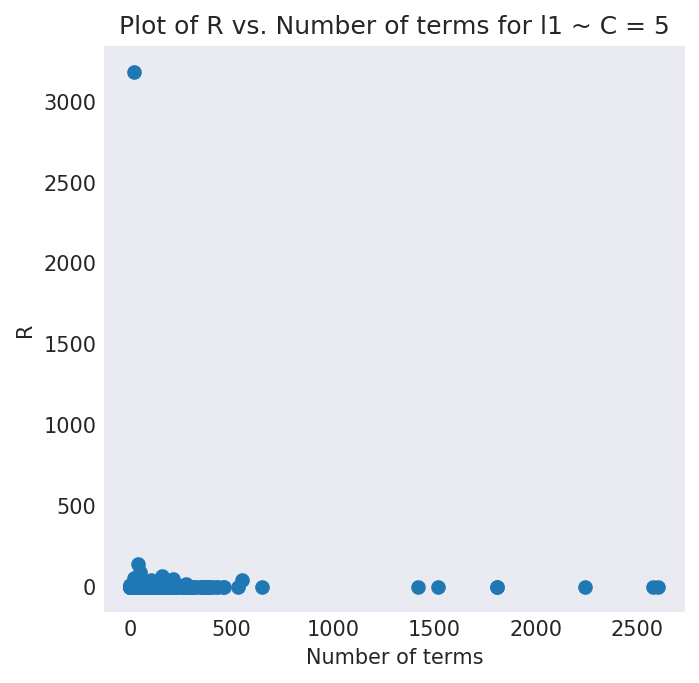

             precision    recall  f1-score   support

          0       0.66      0.54      0.59       165
          1       0.87      0.84      0.85       185
          2       0.72      0.86      0.78       199
          3       0.60      0.59      0.60       127

avg / total       0.72      0.73      0.72       676

Top 3 R values for l1 ~ C=10 : [  705.673068     869.06327552 32255.45373723]


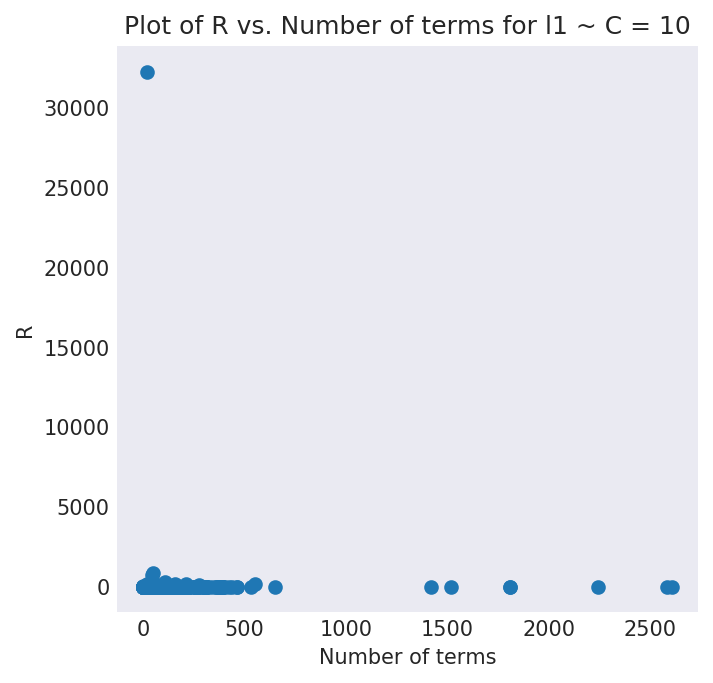

             precision    recall  f1-score   support

          0       0.66      0.55      0.60       165
          1       0.85      0.85      0.85       185
          2       0.74      0.85      0.79       199
          3       0.60      0.60      0.60       127

avg / total       0.73      0.73      0.73       676

Top 3 R values for l1 ~ C=20 : [  1823.01040912   7169.0164789  306899.4509298 ]


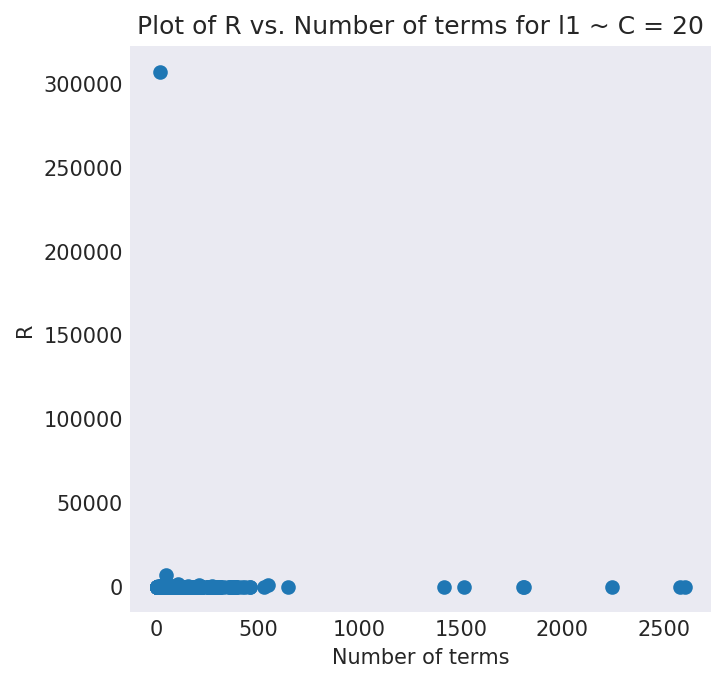

             precision    recall  f1-score   support

          0       0.65      0.56      0.60       165
          1       0.78      0.86      0.82       185
          2       0.78      0.78      0.78       199
          3       0.59      0.60      0.59       127

avg / total       0.71      0.72      0.71       676

Top 3 R values for l1 ~ C=30 : [  5613.74435503  24977.68750667 924696.42565796]


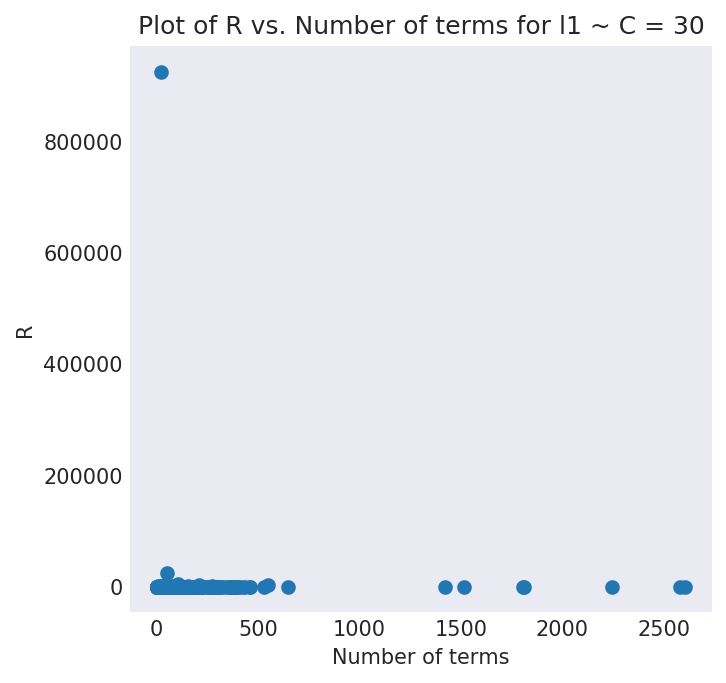

             precision    recall  f1-score   support

          0       0.63      0.56      0.59       165
          1       0.78      0.86      0.82       185
          2       0.78      0.76      0.77       199
          3       0.57      0.58      0.58       127

avg / total       0.70      0.71      0.70       676

Top 3 R values for l1 ~ C=50 : [  22648.04397129  137106.49852782 5122323.96703965]


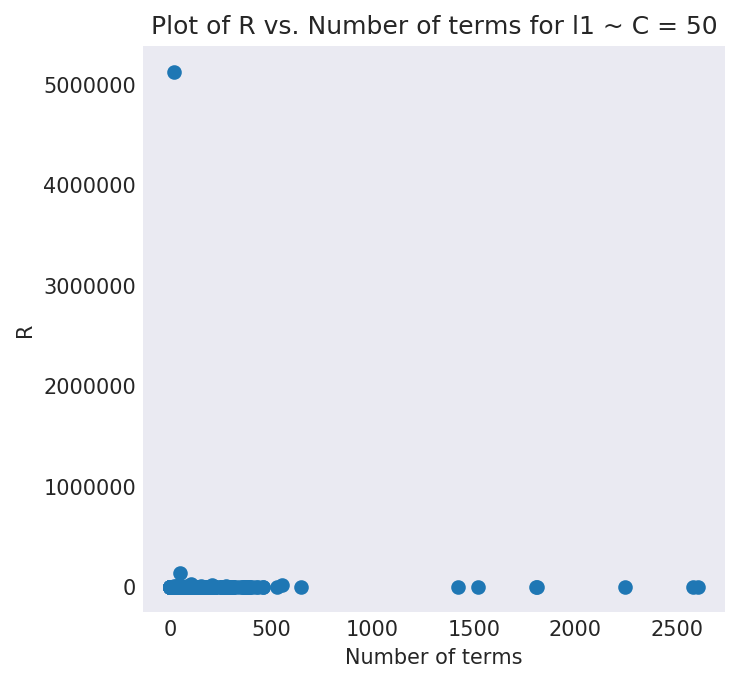

             precision    recall  f1-score   support

          0       0.61      0.55      0.58       165
          1       0.78      0.86      0.82       185
          2       0.78      0.76      0.77       199
          3       0.55      0.56      0.56       127

avg / total       0.70      0.70      0.70       676



In [47]:

def create_LR_and_predict(penalty, c, stop_words = []):
    """
    Create Logistic Regression classifier, fit the train data and the plot chart of R vs. correct probability and run classification report
    """    

    # Analyzer to stem words in docs
    analyzer = TfidfVectorizer().build_analyzer()
    
    def better_analyzer(doc):        
        return (w for w in analyzer(doc) if not w in stop_words)

    t_cv = TfidfVectorizer(analyzer=better_analyzer)
    tfidf = t_cv.fit_transform(train_data)

    # Create LR classifier and fit to tfidf ( from train data )
    clf = LogisticRegression(penalty=penalty,C=c)
    clf.fit(tfidf,train_labels)

    # Create tfidf from dev_data and predict based on LR classifier
    tfidf_dev = t_cv.transform(dev_data)
    p = clf.predict_proba(tfidf_dev)

    # Create mask to extract probability for correct label
    mask = [ (i==0,i==1,i==2,i==3) for i in dev_labels ]
    correct_prob = np.extract(mask, p)
    Rc = list(zip(np.divide(p.max(axis=1), correct_prob),correct_prob))

    # Get top3 R values
    print('Top 3 R values for {2} ~ C={1} : {0}'.format(np.sort([x for x,y in Rc])[-3:],c,penalty))

    Rx = tfidf_dev.getnnz(axis=1)
    Ry = [ r[0] for r in Rc]

    # Plot R vs. # terms per document (scatter)
    plt.rcParams['figure.figsize'] = (5,5)
    plt.rcParams['figure.dpi'] = 150
    plt.scatter(Rx,Ry)
    plt.ylabel('R')
    plt.xlabel('Number of terms')
    plt.title('Plot of R vs. Number of terms for {1} ~ C = {0}'.format(c,penalty))
    plt.show()

    # Get classification report
    p2 = clf.predict(tfidf_dev)
    print (classification_report(dev_labels, p2))

    
for c in (0.1,0.5,0.9,1,5,10,20,30,50):
    create_LR_and_predict("l1", c)


The best f1-score was achieved around C ~ 10, with an f1-score of 0.73 however our values of R in my opinion feel too large and we are looking for a better solution. 
Finally I considered stopping the words that are the most infrequent as the infrequent words appear to be those causing the issue. 

Next, I try removing top and/or bottom words with regularization. To conclude, I find taking the words with low tfidf scores and using l2 regularization improves my score to an f1-score of 0.77. It would be good to understand what would be considered an "acceptable" ratio for R ( upper / lower bounds )

Top 3 R values for l2 ~ C=0.9 : [3.99943075 6.16033773 8.59896706]


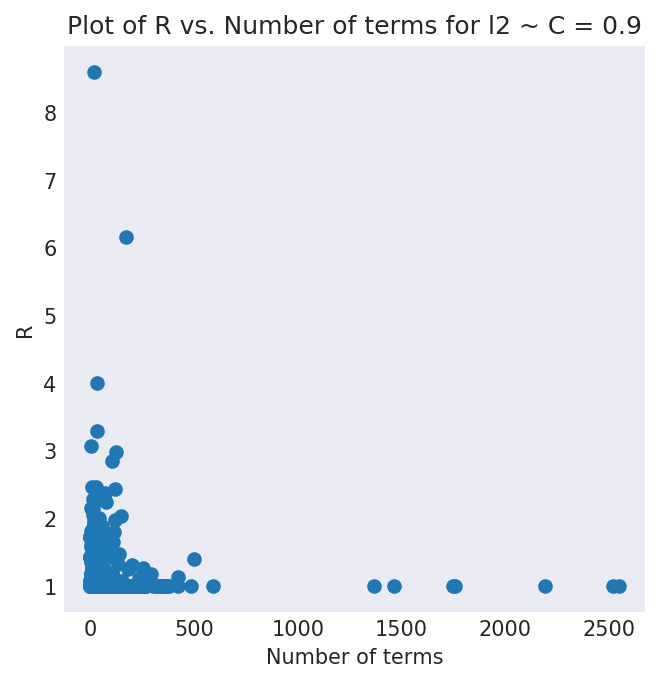

             precision    recall  f1-score   support

          0       0.68      0.56      0.61       165
          1       0.84      0.90      0.87       185
          2       0.68      0.92      0.78       199
          3       0.69      0.39      0.49       127

avg / total       0.72      0.73      0.71       676

Top 3 R values for l2 ~ C=1 : [4.19690833 6.65933669 9.2725472 ]


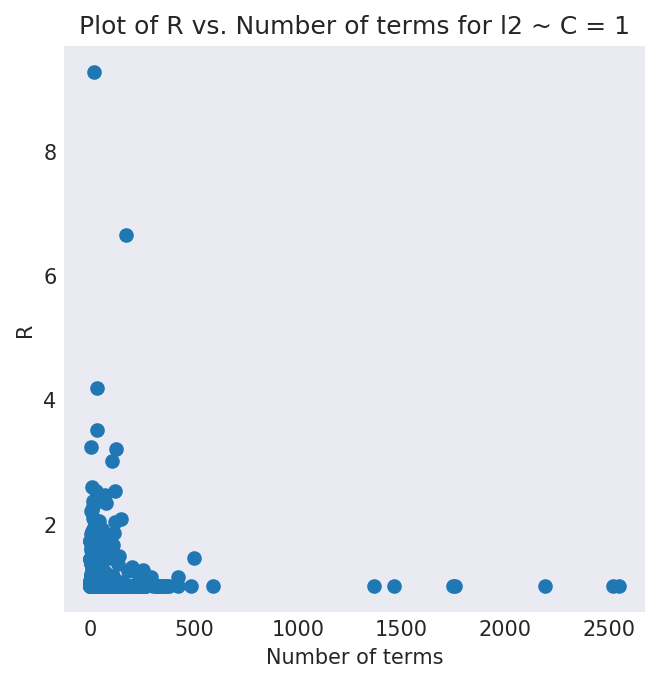

             precision    recall  f1-score   support

          0       0.67      0.53      0.59       165
          1       0.84      0.90      0.87       185
          2       0.68      0.92      0.79       199
          3       0.67      0.41      0.51       127

avg / total       0.72      0.72      0.71       676

Top 3 R values for l2 ~ C=5 : [11.09645671 30.39268912 34.44705859]


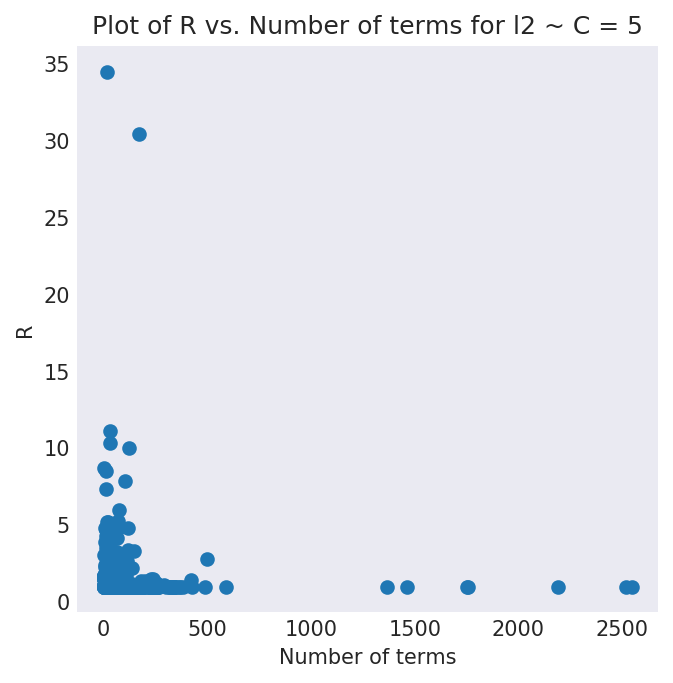

             precision    recall  f1-score   support

          0       0.68      0.61      0.64       165
          1       0.86      0.91      0.88       185
          2       0.76      0.90      0.82       199
          3       0.71      0.53      0.60       127

avg / total       0.76      0.76      0.75       676

Top 3 R values for l2 ~ C=10 : [19.18443015 66.03264336 69.46385063]


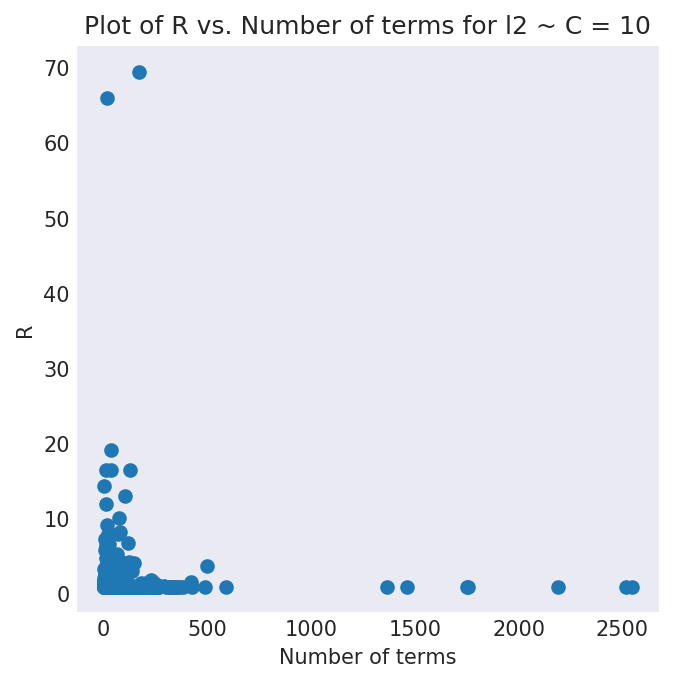

             precision    recall  f1-score   support

          0       0.68      0.61      0.65       165
          1       0.86      0.91      0.88       185
          2       0.77      0.90      0.83       199
          3       0.71      0.54      0.61       127

avg / total       0.76      0.77      0.76       676

Top 3 R values for l2 ~ C=20 : [ 32.67485221 131.33248343 174.18195636]


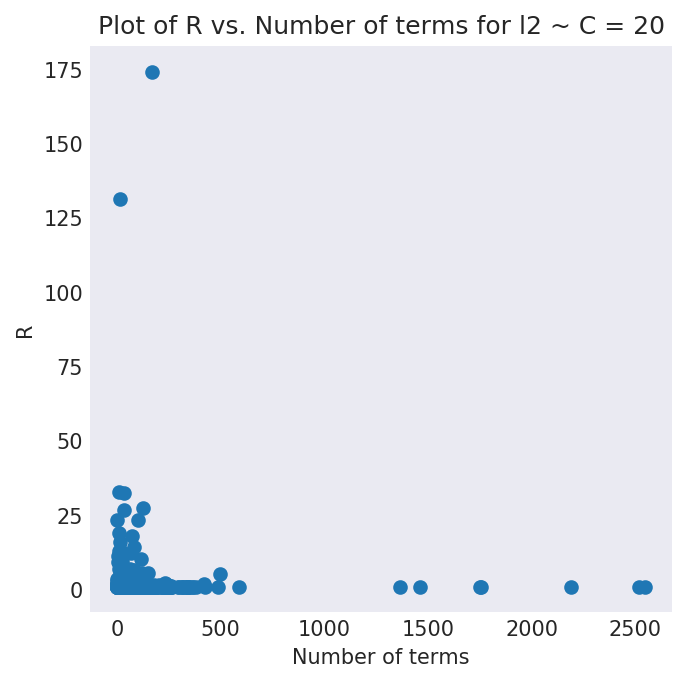

             precision    recall  f1-score   support

          0       0.68      0.62      0.65       165
          1       0.86      0.91      0.89       185
          2       0.77      0.89      0.82       199
          3       0.70      0.54      0.61       127

avg / total       0.76      0.76      0.76       676

Top 3 R values for l2 ~ C=30 : [ 48.36173203 198.75341005 310.90655109]


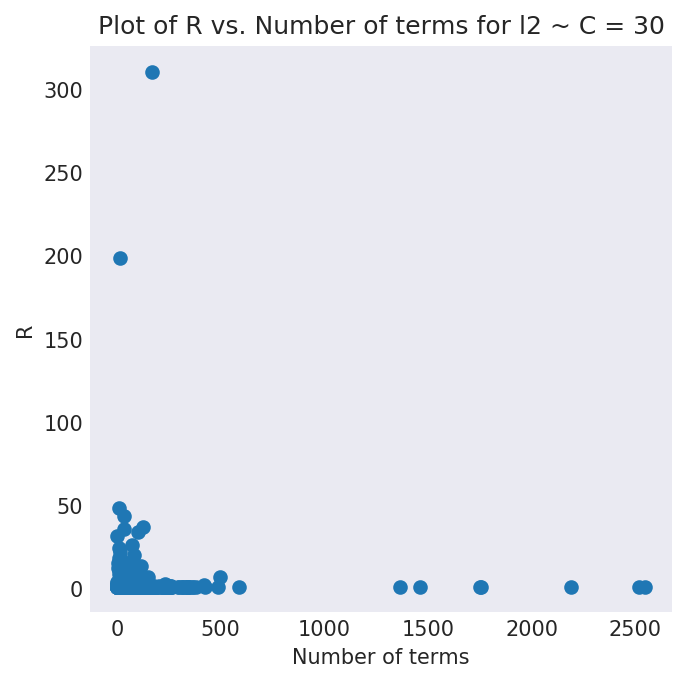

             precision    recall  f1-score   support

          0       0.68      0.62      0.65       165
          1       0.87      0.91      0.89       185
          2       0.77      0.88      0.82       199
          3       0.69      0.55      0.61       127

avg / total       0.76      0.76      0.76       676

Top 3 R values for l2 ~ C=50 : [ 78.22983761 339.12739712 671.61009899]


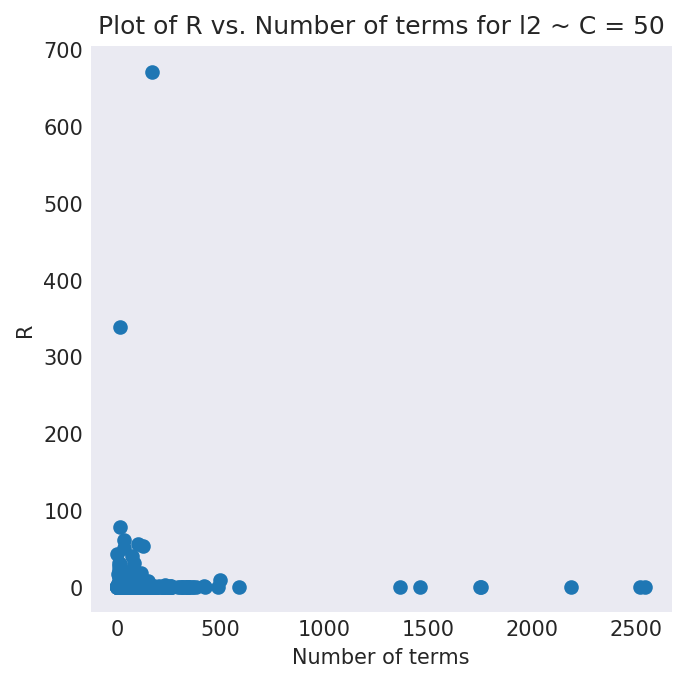

             precision    recall  f1-score   support

          0       0.68      0.62      0.65       165
          1       0.87      0.92      0.89       185
          2       0.78      0.88      0.83       199
          3       0.70      0.58      0.64       127

avg / total       0.77      0.77      0.77       676



In [48]:
# get the most infrequent words

t_cv = TfidfVectorizer()
tfidf = t_cv.fit_transform(train_data)

features = np.array(t_cv.get_feature_names())
tfidfs = pd.DataFrame(tfidf.todense(),
                      columns=features)

# Get totals per word, then remove top X and bottom Y items based on value
tfidfs_sum = tfidfs.sum(axis=0)
tfidfs_sum.sort_values(ascending=False, inplace=True)

#stop_words=tfidfs_sum[tfidfs_sum>20].index
stop_words.union(tfidfs_sum[tfidfs_sum<0.02].index)


# Re-run exercise from above
for c in (0.9,1,5,10,20,30,50):
    create_LR_and_predict("l2", c, stop_words = stop_words)

